# Overview for the grades of the Abitur years from 2006 to 2022

This notebook aims to explore the evolution of the Abitur grades and how they have changed over the years. The data is taken from the [Kultusminister Konferenz](https://www.kmk.org/dokumentation-statistik/statistik/schulstatistik/abiturnoten.html) and is downloaded via the developed download script of this framework.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import school_analysis as sa
import matplotlib.pyplot as plt
from tueplots.constants.color import rgb

from school_analysis.preprocessing.load import Loader

RAW_PATH = os.path.join(sa.PROJECT_PATH, "data", "raw", "abi")
loader = Loader()

In [3]:
# Download data if it doesn't exist yet
if os.path.exists(RAW_PATH):
    print("Raw data already exists, skipping download")
else:
    print("Downloading raw data")
    %run ../src/school_analysis/download_all.py --keep-raw abi

Raw data already exists, skipping download


## Load data


In [4]:
grades_flat = loader.load("abi-grades")
fail_flat = loader.load("abi-fails")
grades = grades_flat.unstack(0).reset_index().rename(
    columns={"level_0": "state", "level_1": "year", 0: "Value"})

## Plot the data


In [5]:
def get_average_grades_by_year_and_state(flat_data: pd.DataFrame, states=["BW"]):
    plot_data: pd.DataFrame = pd.DataFrame()
    for state in states:
        state_data = flat_data[state].copy()
        average_grades_per_year = state_data.apply(lambda col: np.dot(
            col, state_data.index) / col.sum(), axis=0).sort_index()
        plot_data[state] = average_grades_per_year
    return plot_data.copy()

In [6]:
def get_percentage_failed(flat_data: pd.DataFrame, states=["BW"]):
    plot_data: pd.DataFrame = pd.DataFrame()
    for state in states:
        state_data = flat_data[state].copy()
        plot_data[state] = state_data.loc["- nicht bestanden (%)"]
    return plot_data.sort_index().copy()

In [7]:

def get_number_of_final_kids(flat_data: pd.DataFrame, states=["BW"]):
    plot_data: pd.DataFrame = pd.DataFrame()
    for state in states:
        state_data = flat_data[state].copy()
        base = flat_data[state, flat_data[state].columns.sort_values()[0]]
        base_sum = (base["- bestanden"] + base["- nicht bestanden (abs.)"])
        plot_data[state] = (state_data.loc["- bestanden"] +
                            state_data.loc["- nicht bestanden (abs.)"] - base_sum) / base_sum
    return plot_data.sort_index().copy()

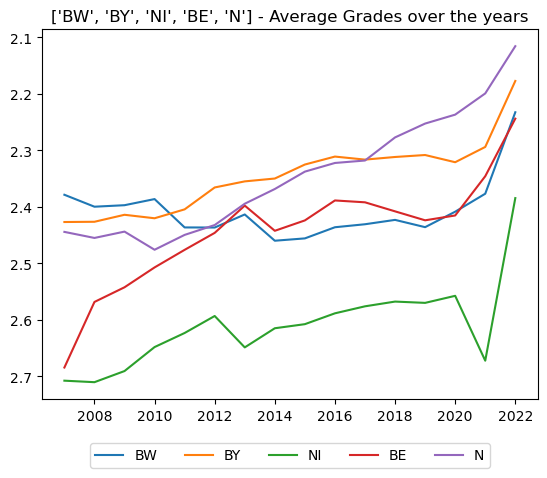

In [33]:
STATES = ["BW", "BY", "NI", "BE", "N"]


fig, axs = plt.subplots(1, 1)
axs.set_title(f"{STATES} - Average Grades over the years")
data = get_average_grades_by_year_and_state(grades_flat, STATES)
data.index = data.index.astype(int)
axs.plot(data)
axs.invert_yaxis()
axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
           ncol=len(data.columns), labels=data.columns)
plt.show()

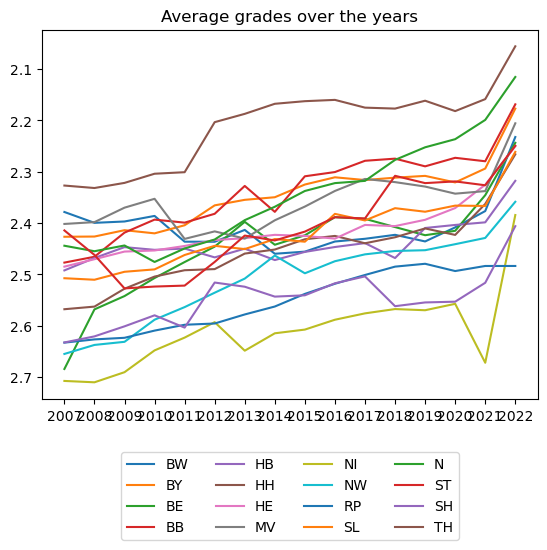

In [32]:

plot_data = get_average_grades_by_year_and_state(
    grades_flat, grades_flat.columns.get_level_values(0))
data.index = data.index.astype(int)
fig, axs = plt.subplots(1, 1)
ax = axs
ax.set_title('Average grades over the years')
ax.plot(plot_data)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4),
          ncol=len(plot_data.columns)/4, labels=plot_data.columns)
ax.invert_yaxis()
plt.show()

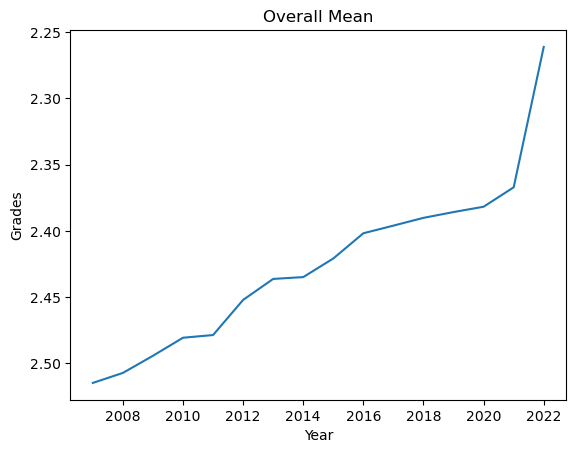

In [31]:
data = get_average_grades_by_year_and_state(
    grades_flat, grades_flat.columns.get_level_values(0))
data.index = data.index.astype(int)
overall_mean = data.mean(axis=1)
fig, axs = plt.subplots(1, 1)

ax = axs
ax.set_title("Overall Mean")
ax.plot(overall_mean)
ax.set_xlabel("Year")
ax.set_ylabel("Grades")
ax.invert_yaxis()
plt.show()

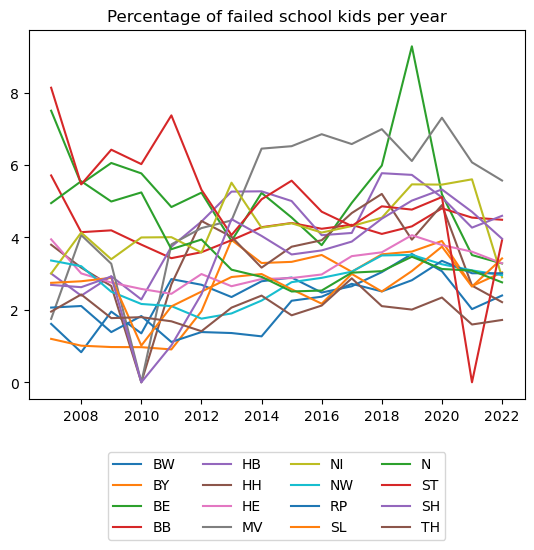

In [30]:
data = get_percentage_failed(fail_flat, fail_flat.columns.get_level_values(0))
data.index = data.index.astype(int)
fig, ax = plt.subplots(1, 1)
ax.plot(data)
ax.set_title("Percentage of failed school kids per year")
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4),
          ncol=len(data.columns)/4, labels=data.columns)
plt.show()

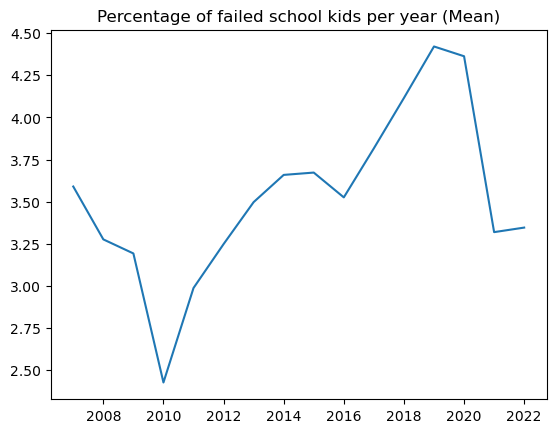

In [29]:
data = get_percentage_failed(fail_flat, fail_flat.columns.get_level_values(0))
data.index = data.index.astype(int)
data = data.mean(axis=1)
fig, ax = plt.subplots(1, 1)
ax.plot(data)
ax.set_title("Percentage of failed school kids per year (Mean)")
plt.show()

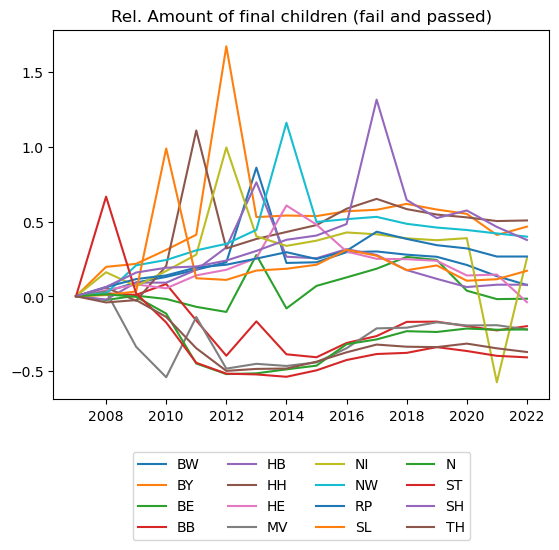

In [28]:
data = get_number_of_final_kids(
    fail_flat, fail_flat.columns.get_level_values(0))
data.index = data.index.astype(int)
fig, ax = plt.subplots(1, 1)
ax.plot(data)
ax.set_title("Rel. Amount of final children (fail and passed)")
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4),
          ncol=len(data.columns)/4, labels=data.columns)
plt.show()

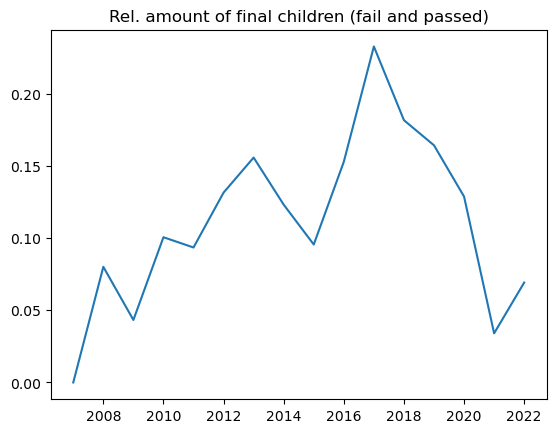

In [27]:
data = get_number_of_final_kids(
    fail_flat, fail_flat.columns.get_level_values(0))
data.index = data.index.astype(int)
data = data.mean(axis=1)
fig, ax = plt.subplots(1, 1)
ax.plot(data)
ax.set_title("Rel. amount of final children (fail and passed)")
plt.show()

## Deeper Analysis on the grades over the years


In [15]:
def group_by_grades(data: pd.DataFrame, group_by: float = 1.0) -> pd.DataFrame:
    data_c = data.copy()
    result = pd.DataFrame(columns=data_c.columns)

    # Check groups
    assert group_by > 0 and group_by <= 4.0, "Group_by > 0 and <= 4.0"

    # Create bounds
    bounds = [i/10 for i in range(10, 41, int(group_by*10))][1:]

    # Group
    for i, b in enumerate(bounds):
        lower_bound = 0.9 if i == 0 else bounds[i-1]
        upper_bound = b

        selected = data_c[(data_c.index <= upper_bound) &
                          (data_c.index > lower_bound)]
        result.loc[f"{lower_bound + 0.1 if i == 0 else bounds[i-1]} - {b}"] = selected.sum(
            axis=0)

    return result


group_half_grades = group_by_grades(grades_flat, 0.5)
group_half_grades

BW                                                        \
              2015     2016     2017     2018     2019     2020     2021   
1.0 - 1.5   4301.0   4867.0   4994.0   5117.0   4959.0   5183.0   5642.0   
1.5 - 2.0   8610.0   9269.0   9481.0   9443.0   8926.0   8872.0   8608.0   
2.0 - 2.5  12767.0  13638.0  13585.0  12912.0  12704.0  12282.0  11504.0   
2.5 - 3.0  13210.0  13973.0  13613.0  13557.0  13382.0  12607.0  11480.0   
3.0 - 3.5   8634.0   8657.0   8759.0   8461.0   8701.0   7855.0   7131.0   
3.5 - 4.0    706.0    697.0    765.0    660.0    667.0    637.0    610.0   

                                      ...      TH                          \
              2022     2010     2011  ...    2021    2022    2010    2011   
1.0 - 1.5   7619.0   5110.0   4322.0  ...  1232.0  1502.0  1124.0   917.0   
1.5 - 2.0   9501.0   8637.0   8473.0  ...  1624.0  1671.0  1925.0  1423.0   
2.0 - 2.5  10762.0  12017.0  12379.0  ...  1796.0  1633.0  2331.0  1737.0   
2.5 - 3.0   9304.0  11874.0  12679.0  ...  1354.0  1131.0  2150.0  1563.0   
3.0 - 3.5   4938.0   6848.0   7812.0  ...   515.0   334.0  1038.0   852.0   
3.5 - 4.0    340.0    594.0    612.0  ...    13.0     8.0    58.0    44.0   

                                                           
             2012    2013    2014    2007    2008    2009  
1.0 - 1.5   846.0   906.0   937.0  1206.0  1168.0  1240.0  
1.5 - 2.0  1236.0  1308.0  1278.0  2192.0  2016.0  2152.0  
2.0 - 2.5  1376.0  1361.0  1423.0  2731.0  2621.0  2582.0  
2.5 - 3.0  1104.0  1058.0  1089.0  2526.0  2435.0  2428.0  
3.0 - 3.5   454.0   483.0   400.0  1254.0  1221.0  1269.0  
3.5 - 4.0    14.0    12.0     9.0    84.0    72.0    82.0  

[6 rows x 256 columns]

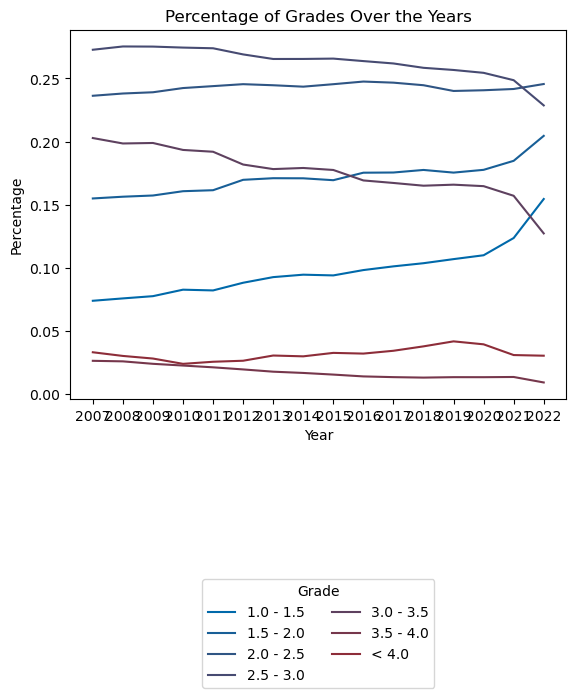

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Settings
STATES = grades_flat.columns.get_level_values(0)
# STATES = ["BW"]
GROUP = 0.5

# Group grades and add failed people
grouped = group_by_grades(grades_flat, GROUP)
grouped.loc["< 4.0"] = fail_flat.loc["- nicht bestanden (abs.)"]

# Get the percentage with grade


def get_percentage_with_grade(data: pd.DataFrame, states: list) -> pd.DataFrame:
    plot_data = pd.DataFrame()
    data_c = data.copy()
    for i, state in enumerate(states):
        if i != 0:
            plot_data += data_c[state]
        else:
            plot_data = data_c[state].copy()
    plot_data = plot_data.apply(lambda col: col / col.sum()).sort_index(axis=1)
    return plot_data.copy()


# Produce the right format
plot_data = get_percentage_with_grade(grouped, STATES).reset_index()
plot_data = plot_data.rename(columns={'index': 'Grade_Range'})
plot_data = pd.melt(plot_data, id_vars='Grade_Range', var_name='Year',
                    value_name='Percentage', value_vars=plot_data.columns.to_list()[1:])

# Create a linear gradient of colors from tue_blue to tue_red
num_grades = len(plot_data["Grade_Range"].unique())
colors = [
    (
        rgb.tue_blue[0] + (rgb.tue_red[0] - rgb.tue_blue[0]
                           ) * (i / (num_grades - 1)),
        rgb.tue_blue[1] + (rgb.tue_red[1] - rgb.tue_blue[1]
                           ) * (i / (num_grades - 1)),
        rgb.tue_blue[2] + (rgb.tue_red[2] - rgb.tue_blue[2]
                           ) * (i / (num_grades - 1)),
    )
    for i in range(num_grades)
]

# Plotting magic
fig, axs = plt.subplots(1, 1)
ax = axs
for i, g_range in enumerate(plot_data['Grade_Range'].unique().tolist()):
    group_data = plot_data.loc[plot_data['Grade_Range'] == g_range]

    ax.plot(
        group_data["Year"],
        group_data["Percentage"],
        color=colors[i],
    )
ax.set_title('Percentage of Grades Over the Years')
ax.set_xlabel('Year')
ax.set_ylabel('Percentage')
g_ranges = plot_data['Grade_Range'].unique().tolist()
ax.legend(title='Grade', loc='lower center', bbox_to_anchor=(
    0.5, -0.8), ncol=len(g_ranges) // 3, labels=g_ranges)
plt.show()

## Linear Regression on the grades

This section aims to display the difference between the regression of previous trends to the changes in the grades after covid.


In [17]:
all_states = grades["state"].unique()

# Create melted df (better for computation)
melted_data = grades.copy()
failed = fail_flat.loc["- nicht bestanden (abs.)"].reset_index().rename(
    columns={"level_0": "state", "level_1": "year", "- nicht bestanden (abs.)": "Value"})
failed["grade"] = 5.0
melted_data = melted_data.rename(columns={'Grade': 'grade'})
melted_data = pd.concat([melted_data, failed]).reset_index(drop=True)
melted_data["year"] = melted_data['year'].astype(np.int32)
melted_data

,state,year,grade,Value
0,BW,2015,1.0,619.0
1,BW,2015,1.1,391.0
2,BW,2015,1.2,547.0
3,BW,2015,1.3,709.0
4,BW,2015,1.4,912.0
...,...,...,...,...
8187,TH,2013,5.0,108.0
8188,TH,2014,5.0,126.0
8189,TH,2007,5.0,199.0
8190,TH,2008,5.0,237.0


Regression on average grade for complete germany


w=[ 2.59222074e+01 -1.16624674e-02]; res=[0.00042497]


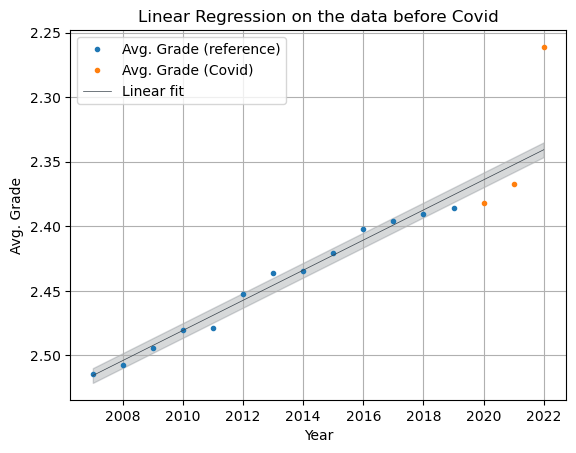

In [18]:
REFERENCE_BEFORE = 2020

data = get_average_grades_by_year_and_state(
    grades_flat, grades_flat.columns.get_level_values(0))
overall_mean = data.mean(axis=1)
overall_mean = overall_mean.reset_index().rename(
    columns={'index': 'year', 0: 'grade'})
overall_mean["year"] = overall_mean["year"].astype(np.int32)

reg_data = overall_mean.copy()
reg_data = reg_data.drop(
    reg_data[reg_data["year"].astype(np.int32) >= REFERENCE_BEFORE].index)

reg_data["year"] = reg_data["year"].astype(np.int32)
# reg_data['year'] = pd.to_numeric(reg_data['year'])
X = np.array([[1, reg_data["year"].iloc[i]] for i in range(reg_data.shape[0])])
y = np.array(reg_data["grade"])

w, res, _, _ = np.linalg.lstsq(X, y, rcond=None)
print(f"w={w}; res={res}")

fig, ax = plt.subplots()

ax.plot(
    reg_data["year"],
    reg_data["grade"],
    ".",
    label="Avg. Grade (reference)",
    lw=0.5,
)

ax.plot(
    overall_mean.loc[overall_mean["year"] >= REFERENCE_BEFORE, "year"],
    overall_mean.loc[overall_mean["year"] >= REFERENCE_BEFORE, "grade"],
    ".",
    label="Avg. Grade (Covid)",
    lw=0.5,
)

xp = overall_mean["year"].unique().astype(np.int32)
ax.plot(
    xp, w[0] + w[1] * (xp), label="Linear fit", color=rgb.tue_dark, lw=0.5
)
ax.invert_yaxis()


ax.fill_between(
    xp,
    w[0] + w[1] * (xp) - np.sqrt(res / len(y)),
    w[0] + w[1] * (xp) + np.sqrt(res / len(y)),
    alpha=0.2,
    color=rgb.tue_dark,
)

ax.grid(True)
ax.set_xlabel("Year")
ax.set_ylabel("Avg. Grade")
ax.legend()
ax.set_title("Linear Regression on the data before Covid")
plt.show()

Creates a regression for every state, grade based on all years before covid.


In [19]:
melted_data

,state,year,grade,Value
0,BW,2015,1.0,619.0
1,BW,2015,1.1,391.0
2,BW,2015,1.2,547.0
3,BW,2015,1.3,709.0
4,BW,2015,1.4,912.0
...,...,...,...,...
8187,TH,2013,5.0,108.0
8188,TH,2014,5.0,126.0
8189,TH,2007,5.0,199.0
8190,TH,2008,5.0,237.0


In [20]:
melted_data.loc[melted_data["state"] == "BW"].loc[melted_data["year"]
                                                  == 2022].loc[melted_data["grade"] == 1.0]
melted_data.loc[melted_data["year"] == 2022]

,state,year,grade,Value
217,BW,2022,1.0,1588.0
218,BW,2022,1.1,832.0
219,BW,2022,1.2,1067.0
220,BW,2022,1.3,1225.0
221,BW,2022,1.4,1352.0
...,...,...,...,...
8119,SL,2022,5.0,121.0
8135,N,2022,5.0,358.0
8151,ST,2022,5.0,219.0
8167,SH,2022,5.0,487.0


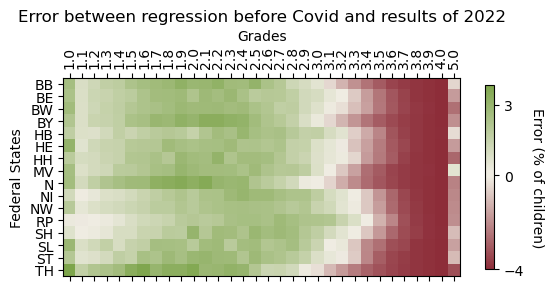

In [21]:
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'melted_data' is your DataFrame
REFERENCE_BEFORE = 2020

reg_data_before = melted_data.copy()
reg_data_before['percentage'] = reg_data_before.groupby(["year", "state"])['Value'].transform(
    lambda group: group / group.sum() * 100 if group.sum() > 0 else 0)
reg_data = reg_data_before.drop(
    reg_data_before[reg_data_before["year"].astype(np.int32) >= REFERENCE_BEFORE].index)

# Create an empty DataFrame to store regression results
results_df = pd.DataFrame(
    columns=["State", "Grade", "Intercept", "Slope", "Residual", "2022-Err"])

for s in reg_data.state.unique():
    state_data = reg_data.loc[reg_data.state == s]
    for g in state_data.grade.unique():
        grade_state_data = state_data.loc[state_data.grade == g]
        X = np.array([[1, grade_state_data["year"].iloc[i] - 2007]
                     for i in range(grade_state_data.shape[0])])
        y = np.array(grade_state_data["grade"])
        w, res, _, _ = np.linalg.lstsq(X, y, rcond=None)

        # Calculate residuals for the year 2022
        residuals_2022 = reg_data_before.loc[reg_data_before["year"] == 2022].loc[reg_data_before["grade"]
                                                                                  == g].loc[reg_data_before["state"] == s, "percentage"].iloc[0] - (w[0] + w[1] * (2022 - 2007))

        # Append results by creating a new DataFrame and concatenating
        results_df.loc[len(results_df.index)] = [
            s, g, w[0], w[1], res[0], residuals_2022]

# Create a pivot table for the heatmap
pivot_table = results_df.pivot(
    index="State", columns="Grade", values="2022-Err")

# create a heatmap-like plot of the pivot table
fig, ax = plt.subplots()
colors = [(0, rgb.tue_red), (0.5, rgb.tue_lightgold),
          (0.53, rgb.tue_lightgold), (1, rgb.tue_green)]
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors)
im = ax.matshow(pivot_table, cmap=custom_cmap)

# set the x-axis and y-axis labels
ax.set_yticks(np.arange(len(pivot_table.index)))
ax.set_yticklabels(pivot_table.index.to_list())
ax.set_ylabel("Federal States")

ax.set_xticks(np.arange(len(pivot_table.columns)))
ax.set_xticklabels(pivot_table.columns.to_list(), rotation=90)
ax.set_xlabel("Grades", loc="center", )
ax.xaxis.set_label_position('top')

# set the colorbar
cbar = ax.figure.colorbar(im, ax=ax, shrink=0.5)
cbar.set_ticks([-4, 0, 3])
cbar.ax.set_ylabel("Error (% of children)", rotation=-90, va="bottom")

# set the plot title
ax.set_title("Error between regression before Covid and results of 2022")

# sns.heatmap(pivot_table, annot=True, fmt=".2f", linewidths=.5)
# plt.title('Regression Residuals Heatmap for 2022')
plt.show()